In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [ ]:
!pip install super-gradients
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 92.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to 

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import super_gradients as sg
from super_gradients.training import models
from torchinfo import summary
from IPython.display import clear_output
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val


In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Small Training Fine Tuning

Let's first create some dataloaders object in order to use as input to out model. This already applies the transformations necessary.

In [ ]:

dataset_params = {
    'data_dir':'/content/drive/MyDrive/Final_Project_DNN',
    'train_images_dir':'train/images_resized',
    'train_labels_dir':'train/labels',
    'small_train_images_dir': 'small_train_set/images_resized',
    'small_train_labels_dir': 'small_train_set/labels',
    'val_images_dir':'validation/images_resized',
    'val_labels_dir':'validation/labels',
    'test_images_dir':'test/images_resized',
    'test_labels_dir':'test/labels',
    'classes': ['Smoke', 'Fire']
}


 The following may take a while to run. Even with GPU's.

In [ ]:
# Training Loader

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

# Small training_set loader

small_train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['small_train_images_dir'],
        'labels_dir': dataset_params['small_train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

# Validation Loader

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

# Test Loader

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Let's explore the data set in use and have an idea of the transformations applied to our transformation data. Transformations applied:

> - DetectionPaddedRescale: Padds images that are smaller than the pretended input size.
> - DetectionMosaic: Mixes up to 4 images and respective labels in one.
> - DetectionRandomAffine: Applies random rottation and or tranlsation to images.
> - DetectionMixup: Blends pairs of samples and their labels and bounding boxes in order to create new, artificial, data.
> - DetectionHSV: Instead of representing the image in RGB it represents the image in HSV. the advantage is that seperates the hue from the saturation.
> - DetectionTargetsFormatTransform: Resizes images from their input shape into an output shape.  
> - DetectionHorizontalFlip: Flips the image by the y-axis.

To edit the transformations applied we can use operations such as we were working with a dictionary. The trasnformations can also be defined while creating the dataset dictionary but it seems to not be as efficient.

In [ ]:
# Transformations applied to the training data
train_data.dataset.transforms

Example of images with data augmentation in training set.

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:487: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)


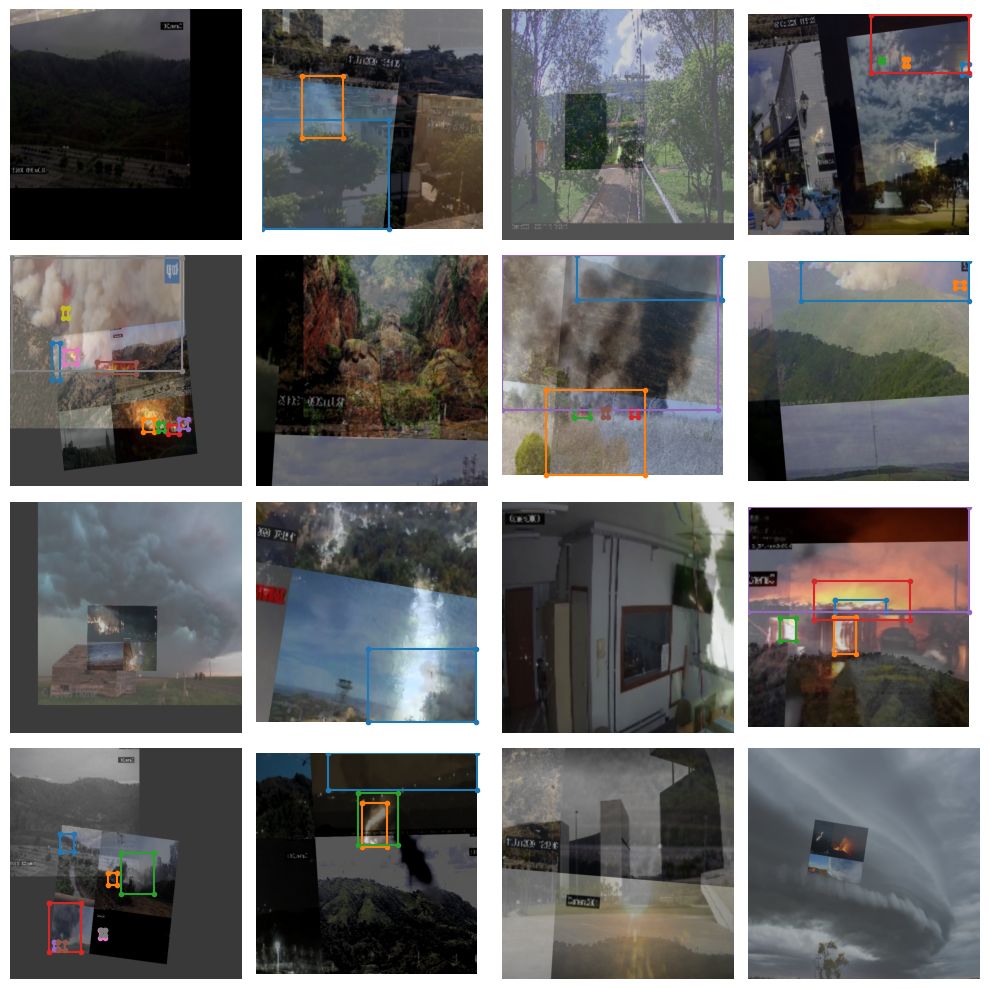

In [ ]:
train_data.dataset.plot()

## Model Training

The function below is to extract the metrics from the experiment logs file the model creates.

In [ ]:
import re
import matplotlib.pyplot as plt

def extract_metrics(file_path):
    # Regular expression pattern to match metrics
    pattern = r"(\w+/\w+|\w+@\d\.\d\d):\s+([\d\.e\-]+)"

    # Dictionary to store metrics
    metrics = {}

    # Read file and process each line
    with open(file_path, 'r') as file:
        for line in file:
            # Find all metric-value pairs in the line
            matches = re.findall(pattern, line)

            # Process each match
            for metric, value in matches:
                # Convert value to float
                value = float(value)

                # Add value to the corresponding metric list in the dictionary
                if metric not in metrics:
                    metrics[metric] = []
                metrics[metric].append(value)

    return metrics





### Baseline

Initializing the trainer and the model.

In [ ]:
from super_gradients.training import Trainer

# checkpoint to save the model and the experiment name
CHECKPOINT_DIR = '/content/drive/MyDrive/Model_checkpoints/Large model/baseline_yolo_nas_checkpoints'
trainer = Trainer(experiment_name = 'baseline_yolo_nas_run', ckpt_root_dir = CHECKPOINT_DIR)

In [ ]:
from super_gradients.training import models

model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   ).to(device)

[2023-11-21 21:39:11] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


In [ ]:
type(model.to(device))

super_gradients.training.models.detection_models.yolo_nas.yolo_nas_variants.YoloNAS_L

Setting the hyper-parameters and evaluation metrics used.

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "lr_warmup_epochs": 0,
    "initial_lr": 3e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0,
    "optimizer": "Adam",
    "zero_weight_decay_on_bias_and_bn": True,
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

Training the model

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to /content/drive/MyDrive/Model_checkpoints/Large model/baseline_yolo_nas_checkpoints/baseline_yolo_nas_run/console_Nov21_21_39_44.txt


[2023-11-21 21:39:44] WARNING - callbacks.py - Parameter linear_step has been made deprecated and will be removed in the next SG release. Please use `linear_epoch_step` instead.
[2023-11-21 21:39:47] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 8845       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         552        (len(train_loader))
    - Gradient updates per epoch:   552        (len(train_loader) / batch_accumulate)

[2023-11-21 21:44:23] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Model_checkpoints/Large model/

In [ ]:
metrics.pop('LR/Param_group_0')
metrics.pop('LR/Param_group_1')
metrics.keys()

dict_keys(['Train_PPYoloELoss/loss_cls', 'Train_PPYoloELoss/loss_iou', 'Train_PPYoloELoss/loss_dfl', 'Train_PPYoloELoss/loss', 'Valid_PPYoloELoss/loss_cls', 'Valid_PPYoloELoss/loss_iou', 'Valid_PPYoloELoss/loss_dfl', 'Valid_PPYoloELoss/loss', 'Valid_Precision@0.50', 'Valid_Recall@0.50', 'Valid_mAP@0.50', 'Valid_F1@0.50'])

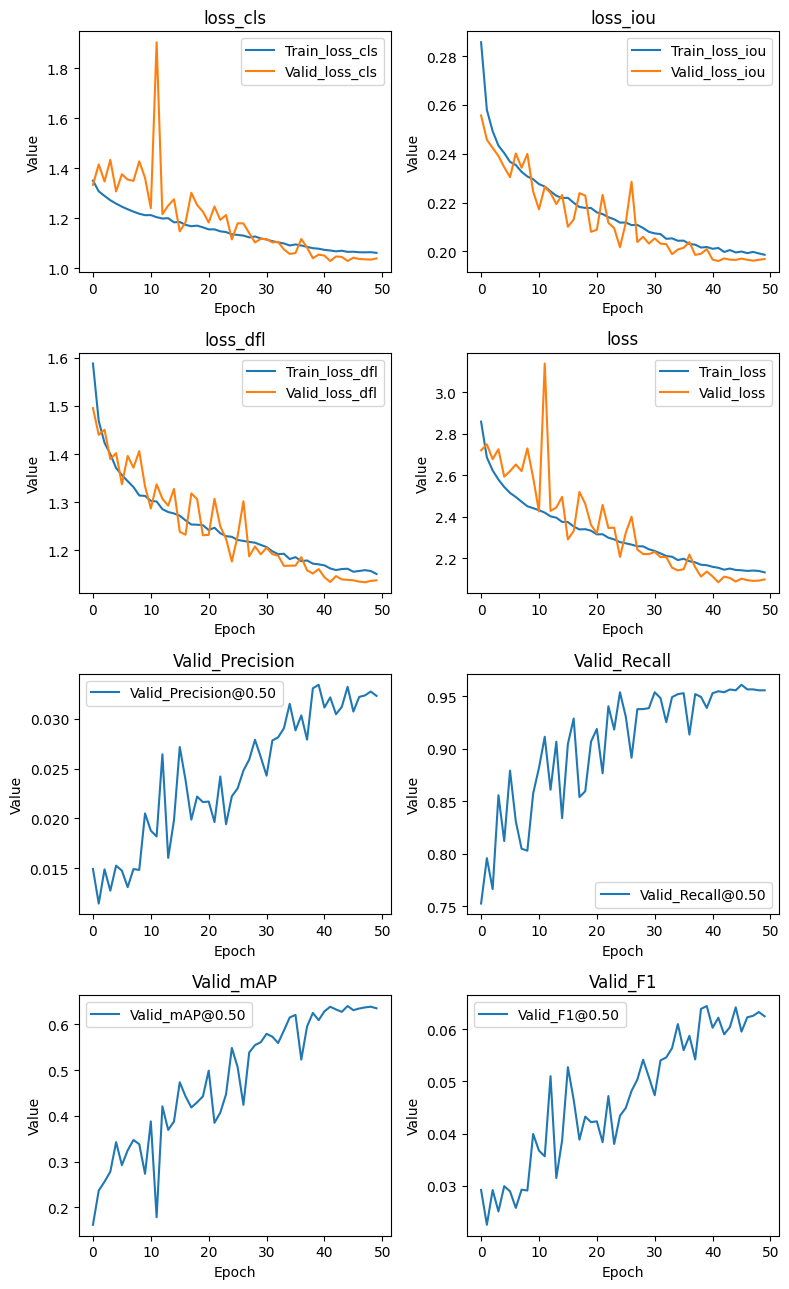

In [ ]:
# File path with the experiment logs
file_path = '/content/drive/MyDrive/Model_checkpoints/Large model/yolo_nas_checkpoints/baseline_yolo_nas_run/experiment_logs_Nov21_21_39_44.txt'
metrics = extract_metrics(file_path)
# Identifying matching metrics for train and valid
pairs = []
# Additional metrics that do not have a corresponding training metric
additional_metrics = []

for key in metrics:
    if key.startswith('Train_'):
        valid_key = key.replace('Train_', 'Valid_')
        if valid_key in metrics:
            pairs.append((key, valid_key))
    elif key.endswith('@0.50'):
      additional_metrics.append(key)


# Determine the grid size for a 2x4 layout
n_cols = 2
n_rows = 4

# Plotting in a 2x4 grid format
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, 13))
axes = axes.flatten()

# Plot the paired metrics
for i, (train_key, valid_key) in enumerate(pairs):
    epochs = range(len(metrics[train_key]))
    axes[i].plot(epochs, metrics[train_key], label=f"Train_{train_key.split('/')[1]}")
    axes[i].plot(epochs, metrics[valid_key], label=f"Valid_{valid_key.split('/')[1]}")
    axes[i].set_title(train_key.split('/')[1])
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Value')
    axes[i].legend()

# Plot the additional validation metrics
for j, metric in enumerate(additional_metrics, start=len(pairs)):
    epochs = range(len(metrics[metric]))
    axes[j].plot(epochs, metrics[metric], label=metric)
    axes[j].set_title(metric.split('@')[0])
    axes[j].set_xlabel('Epoch')
    axes[j].set_ylabel('Value')
    axes[j].legend()

# Hide any unused subplots
for k in range(j+1, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

### Hyper Parameter tuning

Let's set the model in the same way as for the baseline but using a smaller training set.

In [ ]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = '/content/drive/MyDrive/Model_checkpoints/Small model/yolo_nas_checkpoints'

trainer = Trainer(experiment_name = 'hyperparameter_tuning_yolo_nas_run_4', ckpt_root_dir = CHECKPOINT_DIR)

In [ ]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   ).to(device)



[2023-11-22 17:05:35] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-11-22 17:05:35] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


> + Baseline: `mAP@0.5: 0.622` | `Precision@0.50: 0.033` | `Recall@0.50: 0.943`

Below it was performed some trial runs in order to compare models with different hyper parameters. Due to high running times a smaller training set was used and therefore the results should be slightly worse than the baseline. The goal is to get the best hyper parameters possible to then apply them in the model with all the data.

> + Run 1: cosine_final_lr_ratio = 0.1 || Validation metrics: `mAP@0.5: 0.0.488` | `Precision@0.50: 0.027` | `Recall@0.50: 0. 0.914`
> + Run 2: cosine_final_lr_ratio = 0.1 | "optimizer_params": {"weight_decay": 0.0001} || Validation metrics: `mAP@0.5: 0.454` | `Precision@0.50: 0.027` | `Recall@0.50: 0.903`

> + Run 3: cosine_final_lr_ratio = 0.1 + "optimizer_params": {"weight_decay": 0.0001} + 4 warmup epchs with a lr of 3e-6|| Validation metrics: `mAP@0.5: 0.547` | `Precision@0.50: 0.0326` | `Recall@0.50: 0.922` -> Big improvement but noisy

> + Run 4: cosine_final_lr_ratio = 0.1 + "optimizer_params": {"weight_decay": 0.0001} + 4 warmup epchs with a lr of 3e-6 + Exponential moving average (decay = 0.9) || Validation metrics: `mAP@0.5: 0.541` | `Precision@0.50: 0.039` | `Recall@0.50: 0.925` -> Converges with less noise


In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 3e-6,
    "lr_warmup_epochs": 4,
    "initial_lr": 3e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,

        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,

            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=small_train_data,
              valid_loader=val_data)

[2023-11-22 17:05:44] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231122_170544_149382`
[2023-11-22 17:05:44] INFO - sg_trainer.py - Checkpoints directory: /content/drive/MyDrive/Model_checkpoints/Small model/yolo_nas_checkpoints/hyperparameter_tuning_yolo_nas_run_4/RUN_20231122_170544_149382
[2023-11-22 17:05:44] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/drive/MyDrive/Model_checkpoints/Small model/yolo_nas_checkpoints/hyperparameter_tuning_yolo_nas_run_4/RUN_20231122_170544_149382/console_Nov22_17_05_44.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:487: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.

### Best Model: Full Data

In [ ]:
And finally repeat the process for the final model with the full data and the tuned hyper parameters.

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/Model_checkpoints/Large model/final_model_yolo_nas'

trainer = Trainer(experiment_name = 'yolo_nas_final_run', ckpt_root_dir = CHECKPOINT_DIR)

In [ ]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   ).to(device)

[2023-11-22 17:55:21] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-11-22 17:55:22] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 3e-6,
    "lr_warmup_epochs": 4,
    "initial_lr": 3e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 1e-4},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-11-22 17:55:49] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231122_175549_182853`
[2023-11-22 17:55:49] INFO - sg_trainer.py - Checkpoints directory: /content/drive/MyDrive/Model_checkpoints/Large model/final_model_yolo_nas/yolo_nas_final_run/RUN_20231122_175549_182853
[2023-11-22 17:55:49] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/drive/MyDrive/Model_checkpoints/Large model/final_model_yolo_nas/yolo_nas_final_run/RUN_20231122_175549_182853/console_Nov22_17_55_49.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:487: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndar

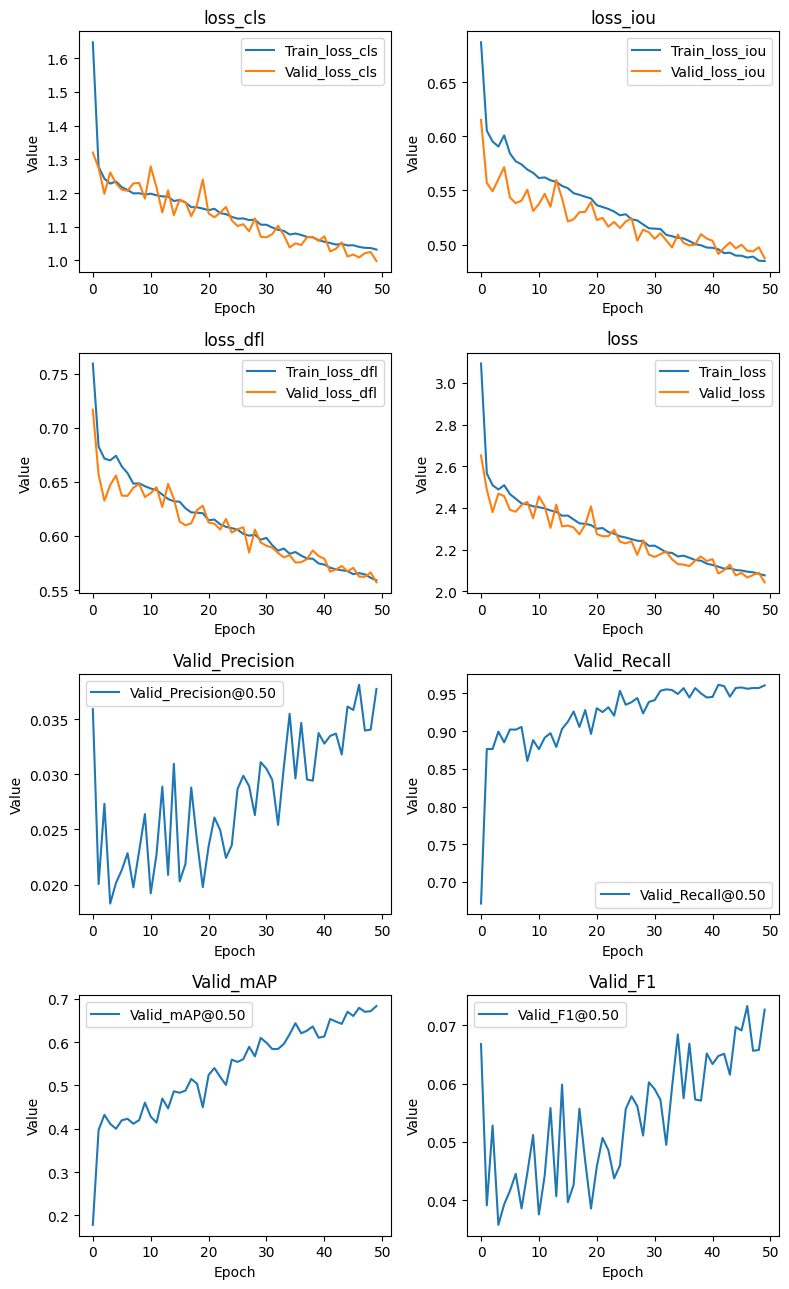

In [ ]:
file_path = '/content/drive/MyDrive/Model_checkpoints/Large model/final_model_yolo_nas/yolo_nas_final_run/RUN_20231122_175549_182853/experiment_logs_Nov22_17_55_49.txt'
metrics = extract_metrics(file_path)

# Identifying matching metrics for train and valid
pairs = []
# Additional metrics that do not have a corresponding training metric
additional_metrics = []

for key in metrics:

    if key.startswith('Train_'):
        valid_key = key.replace('Train_', 'Valid_')
        if valid_key in metrics:
            pairs.append((key, valid_key))
    elif key.endswith('@0.50'):
      additional_metrics.append(key)


# Determine the grid size for a 2x4 layout
n_cols = 2
n_rows = 4

# Plotting in a 2x4 grid format
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, 13))
axes = axes.flatten()

# Plot the paired metrics
for i, (train_key, valid_key) in enumerate(pairs):
    epochs = range(len(metrics[train_key]))
    axes[i].plot(epochs, metrics[train_key], label=f"Train_{train_key.split('/')[1]}")
    axes[i].plot(epochs, metrics[valid_key], label=f"Valid_{valid_key.split('/')[1]}")
    axes[i].set_title(train_key.split('/')[1])
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Value')
    axes[i].legend()

# Plot the additional validation metrics
for j, metric in enumerate(additional_metrics, start=len(pairs)):
    epochs = range(len(metrics[metric]))
    axes[j].plot(epochs, metrics[metric], label=metric)
    axes[j].set_title(metric.split('@')[0])
    axes[j].set_xlabel('Epoch')
    axes[j].set_ylabel('Value')
    axes[j].legend()

# Hide any unused subplots
for k in range(j+1, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

### To reset GPU

It was needed to define a way of reseting the gpu because the GPU was going down after multiple runs to fine the hyper parameters.

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()
device

[2023-11-21 14:57:07] INFO - driver.py - init
[2023-11-21 14:57:07] INFO - driver.py - reset context of device 0


<weakproxy at 0x7dfe48100d60 to Device at 0x7dfcd03826b0>

## Model Evaluation

Getting the mest model out of the checkpoints saved.

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=2,
                        checkpoint_path="/content/drive/MyDrive/Model_checkpoints/Large model/final_model_yolo_nas/yolo_nas_final_run/RUN_20231122_175549_182853/average_model.pth")

[2023-11-23 07:29:39] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Model_checkpoints/Large model/final_model_yolo_nas/yolo_nas_final_run/RUN_20231122_175549_182853/average_model.pth EMA checkpoint.


Testing the model in our test data.

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)))

NameError: ignored

### Prediction Examples

Below follows the code used to obtain some examples of predictions using images in the test set.

In [ ]:
samples
print(samples)
smoke = ['AoF07116.jpg',
          'AoF08107.jpg',
         '']

good = ['AoF07116.jpg', 'WEB10530.jpg', 'WEB11687.jpg', 'WEB10878.jpg', 'WEB11788.jpg', 'WEB10846.jpg', 'WEB10454.jpg', 'AoF07020.jpg', 'PublicDataset01169.jpg', 'WEB11094.jpg', 'WEB10857.jpg']
bad = ["WEB09509.jpg", 'WEB10575.jpg', 'WEB10627.jpg', 'PublicDataset01100.jpg']

['AoF07881.jpg', 'WEB10627.jpg', 'AoF07829.jpg', 'AoF08260.jpg', 'PublicDataset01281.jpg', 'AoF07485.jpg', 'AoF07509.jpg', 'AoF07505.jpg', 'WEB09835.jpg']


In [ ]:
image = cv2.imread("/content/drive/MyDrive/Final_Project_DNN/test/images_resized/WEB10575.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
best_model.predict(image)

[2023-11-23 08:09:24] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


ImagesDetectionPrediction(_images_prediction_lst=[ImageDetectionPrediction(image=array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 25,  24,  22],
        [ 26,  25,  23],
        [ 26,  25,  23]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 25,  24,  22],
        [ 25,  24,  22],
        [ 25,  24,  22]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 24,  23,  21],
        [ 24,  23,  21],
        [ 25,  24,  22]],

       ...,

       [[ 92,  84,  61],
        [100,  92,  69],
        [114, 103,  81],
        ...,
        [124, 109,  80],
        [136, 121,  92],
        [126, 111,  82]],

       [[ 95,  86,  69],
        [ 96,  88,  69],
        [ 94,  86,  67],
        ...,
        [135, 120,  89],
        [139, 126,  94],
        [133, 120,  88]],

       [[103,  94,  79],
        [102,  93,  78],
        [ 92,  83,  66],
      

[2023-11-23 08:07:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


WEB09509.jpg


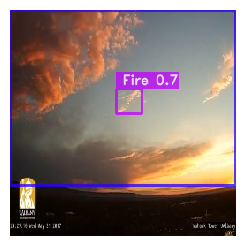

[2023-11-23 08:07:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


WEB10575.jpg


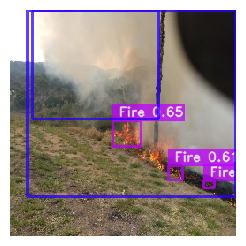

error: ignored

In [ ]:
import random
import cv2

rand_images = random.sample(os.listdir("/content/drive/MyDrive/Final_Project_DNN/test/images_resized"), 9)
samples = []
for image_id in good:
  print(image_id)
  samples.append(image_id)
  image_path = os.path.join("/content/drive/MyDrive/Final_Project_DNN/test/images_resized", image_id)
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  best_model.predict(image).show()
  # print(predict)
  # break

# Video Prediction

Below we access the youtube api in order to obtain a video found online that consists on a news about a fire happening somewhere randomly. The prediction is actually quite good given the format of the video wasn't adjusted to fit the same size used to train the model.

In [ ]:
# Define the URL of the YouTube video

video_id = 'Sqj2bm1VwF0'
video_url = f'https://www.youtube.com/watch?v={video_id}'

# Download the video in mp4 format
!pip install -U "git+https://github.com/ytdl-org/youtube-dl.git"
!python -m youtube_dl -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4' "$video_url"

# Print a success message
print('Video downloaded successfully')

input_video_path = f"/content/EXTREME SPORTS X DIVERSE-{video_id}.mp4"
output_video_path = "detections.mp4"

  Cloning https://github.com/ytdl-org/youtube-dl.git to /tmp/pip-req-build-d7dfi0ct
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl.git /tmp/pip-req-build-d7dfi0ct
  Resolved https://github.com/ytdl-org/youtube-dl.git to commit aaed4884ed9954b8b69c3ca5254418ec578ed0b9
  Preparing metadata (setup.py) ... done
  Created wheel for youtube-dl: filename=youtube_dl-2021.12.17-py2.py3-none-any.whl size=1940261 sha256=e976fd2347e4493544c27bdc06919ac28dfc57ffdd47d858579634e211eed8a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-wr0iiup5/wheels/64/8e/40/866e846163e3e4859bbe820ff8847ec97f4320864f1525aa9a
Successfully built youtube-dl
[youtube] Sqj2bm1VwF0: Downloading webpage
[youtube] Sqj2bm1VwF0: Downloading player 63e90c30
[dashsegments] Total fragments: 2
[download] Destination: Caught on camera - Fort McMurray fire erupts behind Global News reporter-Sqj2bm1VwF0.f137.mp4
[download] 100% of 13.37MiB in 00:01
[dashsegments] Total fragments: 1
[d

In [ ]:


# Download the video in mp4 format
!pip install -U "git+https://github.com/ytdl-org/youtube-dl.git"
!python -m youtube_dl -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4' "$video_url"

# Print a success message
print('Video downloaded successfully')

input_video_path = f"/content/Caught on camera - Fort McMurray fire erupts behind Global News reporter-Sqj2bm1VwF0.mp4"
output_video_path = "detections.mp4"

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video:   0%|          | 0/1667 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numpy/lib/arraypad.py:487: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)
[2023-11-23 08:15:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
Predicting Video: 100%|██████████| 1667/1667 [00:47<00:00, 35.35it/s]
